## Yoga Pose Detection

## Mediapipe Features to be used further

The first thing that we need to do is initialize the pose class using the mp.solutions.pose syntax and then we will call the setup function mp.solutions.pose.Pose() with the arguments:

1. **static_image_mode** - It is a boolean value that is if set to False, the detector is only invoked as needed, that is in the very first frame or when the tracker loses track. If set to True, the person detector is invoked on every input image. So you should probably set this value to True when working with a bunch of unrelated images not videos. Its default value is False.

2. **min_detection_confidence** - It is the minimum detection confidence with range (0.0 , 1.0) required to consider the person-detection model's prediction correct. Its default value is 0.5. This means if the detector has a prediction confidence of greater or equal to 50% then it will be considered as a positive detection.

3. **min_tracking_confidence** - It is the minimum tracking confidence ([0.0, 1.0]) required to consider the landmark-tracking model's tracked pose landmarks valid. If the confidence is less than the set value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is 0.5.

4. **model_complexity** - It is the complexity of the pose landmark model. As there are three different models to choose from so the possible values are 0, 1, or 2. The higher the value, the more accurate the results are, but at the expense of higher latency. Its default value is 1.

5. **smooth_landmarks** - It is a boolean value that is if set to True, pose landmarks across different frames are filtered to reduce noise. But only works when static_image_mode is also set to False. Its default value is True.

Then we will also initialize mp.solutions.drawing_utils class that will allow us to visualize the landmarks after detection, instead of using this, you can also use OpenCV to visualize the landmarks.

## Import Libraries

In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

## Initialize mediapipe

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2) # we are going to use heavy model for better accuracy.

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

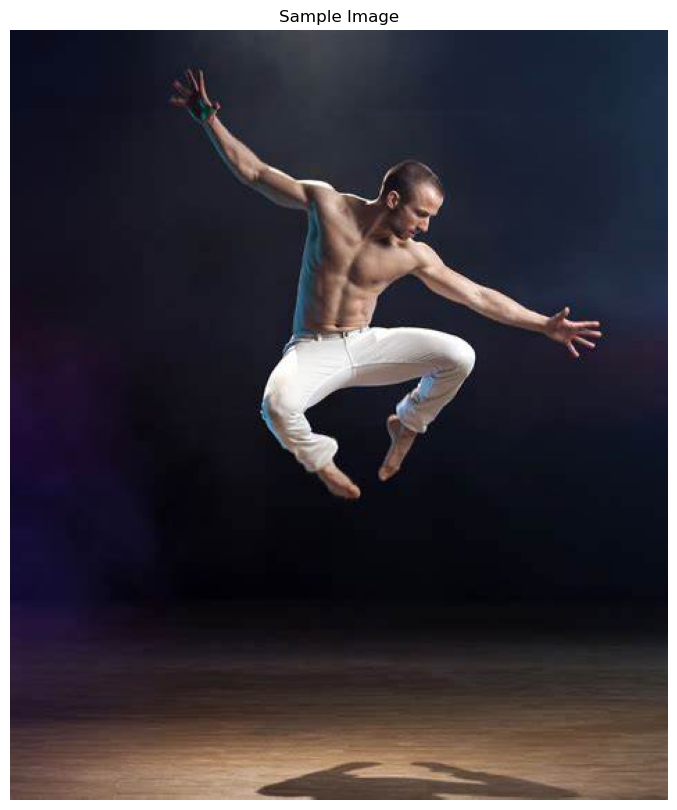

In [3]:
# Read an image from the specified path.
sample_img = cv2.imread('image-1.jpg')

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## Pose Detection

In [4]:
def detectPose(image, pose, display=False):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))

        if display:
            fig = plt.figure(figsize = [10, 10])
            plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        else:
            # Return the output image and the found landmarks.
            return output_image, landmarks

C:\Users\The_Creater\Documents\sample_project\env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


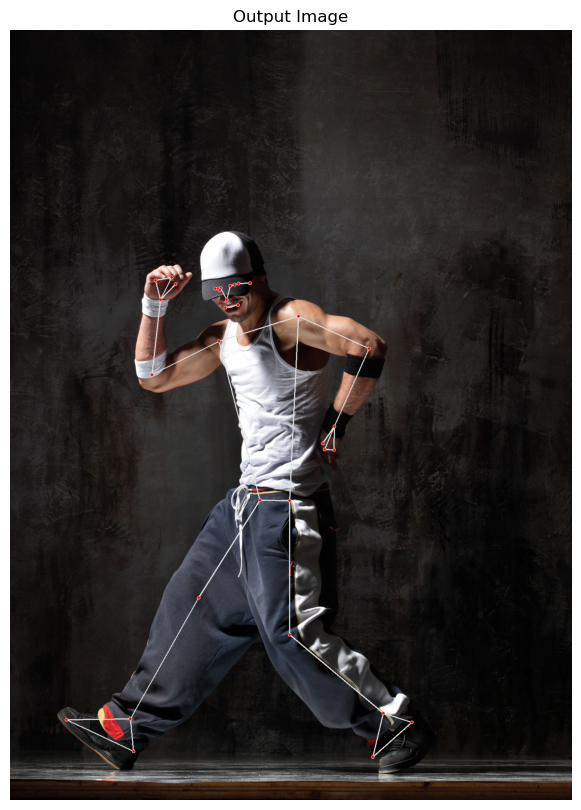

In [5]:
# Read another sample image and perform pose detection on it.
image = cv2.imread('sample-2.jpg')
detectPose(image, pose, display=True)

## Calculate angle

In [6]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Return the calculated angle.
    return angle

In [7]:
# Calculate the angle between the three landmarks.
angle = calculateAngle((958, 326, 0), (942, 0, 0), (720, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 37.4771076201485


## Pre-classification of different yoga pose
This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

In [8]:
def classifyPose(landmarks, output_image, display=True):
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #*******************************************************************************************************************
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #****************************************************************************************************************
    
    # Check if it is the T pose.
    #****************************************************************************************************************
    
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                # Check if both legs are straight
                if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                    # Specify the label of the pose that is tree pose.
                    label = 'T Pose'

    #*******************************************************************************************************************
    
    # Check if it is the tree pose.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:

            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'
                
    #*******************************************************************************************************************
    
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

## Detect pose on an image

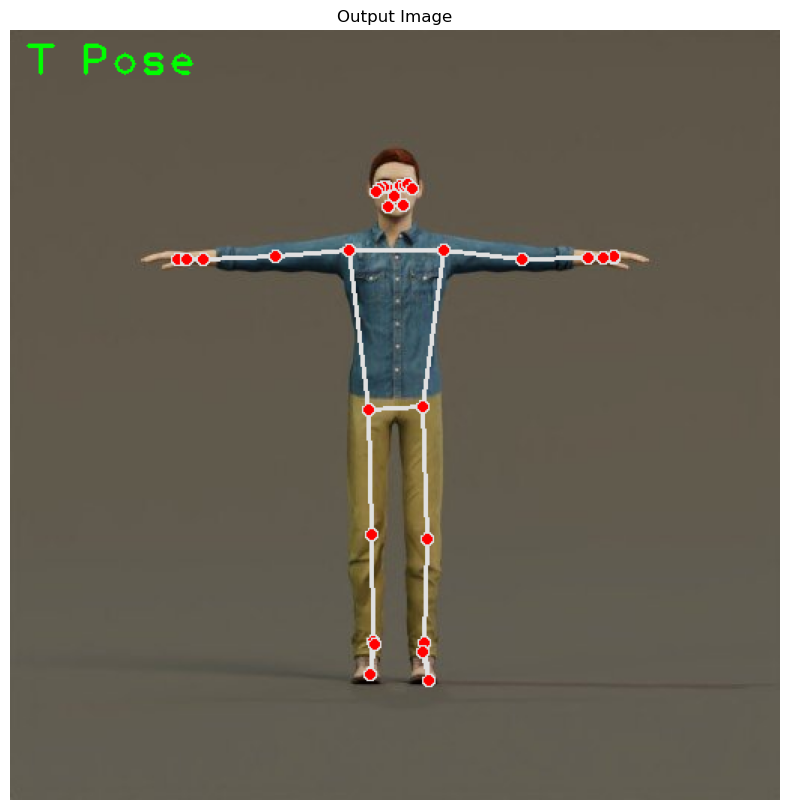

In [9]:
# Read a sample image and perform pose classification on it.
image = cv2.imread('sample-5.jpg')
output_image, landmarks = detectPose(image, mp_pose.Pose(static_image_mode=True,
                                         min_detection_confidence=0.5, model_complexity=0), display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

## Perform Pose detection in real-time using opencv!!

In [10]:
# Create a VideoCapture object to read from the webcam
vid = cv2.VideoCapture(0)

while True:
    ret, frame = vid.read()
    pose_video = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
    frame, landmarks = detectPose(frame, pose_video, display=False)

    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
        
    cv2.imshow('Pose classification', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 